In [1]:
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from datasets import (load_dataset, 
                      load_metric, 
                      load_from_disk,
                      Dataset,
                      DatasetDict
)
from transformers import (
    AutoTokenizer,
    BertModel, BertPreTrainedModel,
    RobertaModel, RobertaPreTrainedModel,
    AdamW, get_linear_schedule_with_warmup,
    TrainingArguments,
)

In [7]:
with open('wikipedia_documents.json', "r", encoding="utf-8") as f:
    wiki = json.load(f)
    
wiki_corpus = list(
    dict.fromkeys([v["text"] for v in wiki.values()])
)

#### wikipedia_documents EDA

In [9]:
print('중복 없는 위키 문서의 개수:', len(list(set(wiki_corpus))))

중복 없는 위키 문서의 개수: 56737


In [26]:
doc_len = np.array([])
for doc in wiki_corpus:
    doc_len = np.append(doc_len, len(doc))

In [27]:
print('가장 긴 document 길이:', doc_len.max())
print('평균 document 길이:', doc_len.mean())
print('가장 짧은 document 길이:', doc_len.min())

가장 긴 document 길이: 46099.0
평균 document 길이: 750.8205932636552
가장 짧은 document 길이: 184.0


In [6]:
import kss

In [8]:

count = 0
for doc in wiki_corpus:
    d = kss.split_sentences(doc)
    for sent in doc:
        count += 1

print('total_setences:', count)

IndexError: list index out of range

<AxesSubplot:>

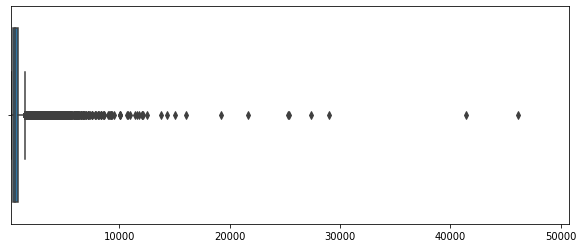

In [34]:
import seaborn as sns

plt.figure(figsize=(10,4))
plt.xlim(doc_len.min(), doc_len.max()*1.1)
sns.boxplot(x=doc_len)

In [38]:
count = 0 
length = 10000
for num in doc_len:
    if num >= length:
        count += 1
print('document의 길이가',length,'이샹인 개수', count)

document의 길이가 10000 이샹인 개수 25


In [52]:
df = pd.DataFrame(doc_len)
df.columns = ['length']

is_over = df['length'] > 10000
over_length = df[is_over]
over_length

,length
578,14309.0
699,12517.0
973,25351.0
3249,10098.0
4529,27406.0
4531,19191.0
4533,41411.0
4534,46099.0
5540,10950.0
5953,29016.0


In [ ]:
idx_list = over_length.index.tolist()
for i, idx in enumerate(idx_list):
    print("passage",i, over_length.iloc[i])
    print(wiki_corpus[idx])
    print()
    

길이가 10000 이상인 문서들을 확인한 결과 <br>
html 태그(?)가 제대로 지워지지 않은 경우도 존재했고, 문자가 많이 깨진 경우도 존재했다. <br>
이를 처리해주는 과정이 필요할 것이라고 생각 <br>

In [63]:
model = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained(model)

In [68]:
tokenized_doc_len = np.array([])
for doc in wiki_corpus:
    tokenized_doc_len = np.append(tokenized_doc_len, len(tokenizer.tokenize(doc)))

In [69]:
print('가장 긴 tokenized document 길이:', tokenized_doc_len.max())
print('평균 tokenized document 길이:', tokenized_doc_len.mean())
print('가장 짧은 tokenized document 길이:', tokenized_doc_len.min())

가장 긴 tokenized document 길이: 27539.0
평균 tokenized document 길이: 401.88920810053406
가장 짧은 tokenized document 길이: 54.0


<AxesSubplot:>

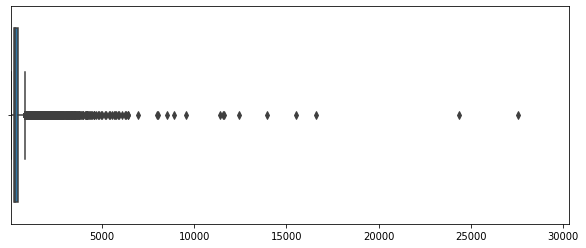

In [71]:
plt.figure(figsize=(10,4))
plt.xlim(tokenized_doc_len.min(), tokenized_doc_len.max()*1.1)
sns.boxplot(x=tokenized_doc_len)

In [76]:
count = 0 
length = 10000
for num in tokenized_doc_len:
    if num >= length:
        count += 1
print('document의 길이가',length,'이샹인 개수', count)

document의 길이가 10000 이샹인 개수 9


In [79]:
df = pd.DataFrame(tokenized_doc_len)
df.columns = ['length']

is_over = df['length'] > 10000
over_length = df[is_over]
over_length

,length
973,12427.0
4529,16618.0
4531,11556.0
4533,24372.0
4534,27539.0
5953,15536.0
10919,13963.0
31111,11587.0
41686,11373.0


In [ ]:
idx_list = over_length.index.tolist()
for i, idx in enumerate(idx_list):
    print("passage",i, over_length.iloc[i])
    print(tokenizer.tokenize(wiki_corpus[idx]))
    print()

In [189]:
tok_doc = tokenizer.tokenize(wiki_corpus[4534])

count = 0
for tok in tok_doc:
    if tok == '[UNK]':
        count += 1
        
print(count / len(tok_doc) * 100)
tok_doc

22.934747085950832


['어딘',
 '실',
 '##이',
 '##니',
 '례',
 '##예',
 '여',
 '##재',
 '##라',
 '○',
 '[UNK]',
 '[UNK]',
 '公',
 '名',
 '[UNK]',
 '[UNK]',
 ',',
 '字',
 '原',
 '明',
 '.',
 '[UNK]',
 '國',
 '正',
 '[UNK]',
 '公',
 '之',
 '長',
 '子',
 '.',
 '正',
 '[UNK]',
 '公',
 '[UNK]',
 '家',
 ',',
 '[UNK]',
 '重',
 '[UNK]',
 '[UNK]',
 ',',
 '不',
 '以',
 '事',
 '物',
 '經',
 '心',
 ',',
 '而',
 '[UNK]',
 '國',
 '夫',
 '人',
 ',',
 '性',
 '[UNK]',
 '有',
 '法',
 '度',
 ',',
 '[UNK]',
 '[UNK]',
 '愛',
 '公',
 ',',
 '然',
 ',',
 '敎',
 '公',
 ',',
 '事',
 '事',
 '[UNK]',
 '[UNK]',
 '規',
 '[UNK]',
 '.',
 '[UNK]',
 '[UNK]',
 '公',
 '의',
 '일',
 '##홈',
 '[UNK]',
 '[UNK]',
 '이오',
 '字',
 '原',
 '明',
 '이니',
 '[UNK]',
 '國',
 '正',
 '[UNK]',
 '公',
 '[',
 '일',
 '##홈',
 '公',
 '[UNK]',
 'ㅣ',
 '##니',
 '[UNK]',
 '은',
 '봉',
 '히',
 '##오',
 '正',
 '[UNK]',
 '은',
 '시',
 '##회',
 '##니',
 '[UNK]',
 '적',
 '[UNK]',
 '라',
 ']',
 '의',
 '아이',
 '##라',
 '正',
 '[UNK]',
 '公',
 '이',
 '집',
 '##의',
 '이',
 '##실',
 '제',
 '간략',
 '##며',
 '[UNK]',
 '잡',
 '##일',
 '아니',
 '##며',
 '잡',
 '##말',


In [86]:
tokenizer.tokenize(wiki_corpus[973])

[':',
 '참고',
 '문헌',
 '목록',
 '##은',
 '제',
 '##1',
 '##차',
 '세계',
 '대전',
 '##의',
 '서지',
 '문서',
 '##를',
 '참조',
 '##하',
 '##십시오',
 '.',
 '*',
 't',
 '##it',
 '##le',
 '=',
 'American',
 'Ar',
 '##m',
 '##ies',
 'and',
 'B',
 '##att',
 '##le',
 '##f',
 '##ield',
 '##s',
 'in',
 'Europe',
 ':',
 'A',
 'History',
 ',',
 'Gu',
 '##ide',
 ',',
 'and',
 'Re',
 '##fer',
 '##ence',
 'Book',
 '|',
 'p',
 '##ubl',
 '##ish',
 '##er',
 '=',
 'US',
 'Go',
 '##vern',
 '##ment',
 'Pr',
 '##int',
 '##ing',
 'Off',
 '##ice',
 '|',
 'y',
 '##ear',
 '=',
 '1938',
 '|',
 'u',
 '##r',
 '##l',
 '=',
 'http',
 ':',
 '/',
 '/',
 'www',
 '.',
 'sec',
 '##st',
 '##ate',
 '.',
 'w',
 '##a',
 '.',
 'go',
 '##v',
 '/',
 'his',
 '##t',
 '##ory',
 '/',
 'w',
 '##w',
 '##1',
 '/',
 'm',
 '##ap',
 '##s',
 '.',
 'as',
 '##p',
 '##x',
 '|',
 'o',
 '##cl',
 '##c',
 '=',
 '59',
 '##80',
 '##37',
 '##0',
 '##6',
 '|',
 'a',
 '##uth',
 '##or',
 '=',
 'American',
 'B',
 '##att',
 '##le',
 'Mon',
 '##um',
 '##ents',
 'Comm',
 '##

글자가 많이 깨지고 한자가 많이 등장했던 문서는 tokenizing이 제대로 안되는 것을 확인할 수 있다.

#### Train / Val EDA

In [10]:
datasets = load_from_disk('../data/train_dataset')
datasets

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 240
    })
})

In [11]:
contexts = datasets['train']['context'] + datasets['validation']['context']

In [12]:
len(contexts)

4192

In [6]:
context = list(set(contexts))

In [97]:
print('중복을 제외한 trian/val 총 context 수:', len(context))

중복을 제외한 trian/val 총 context 수: 3504


In [99]:
a = set(datasets['train']['context']) 
b = set(datasets['validation']['context'])

print('train/val에 공통으로 등장하는 context 수', len(a&b))

train/val에 공통으로 등장하는 context 수 71


In [192]:
train_context = datasets['train']['context']
validation_context = datasets['validation']['context']

In [193]:
train_len = np.array([])
for doc in train_context:
    train_len = np.append(train_len, len(doc))

val_len = np.array([])
for doc in validation_context:
    val_len = np.append(val_len, len(doc))

#### train context 분포

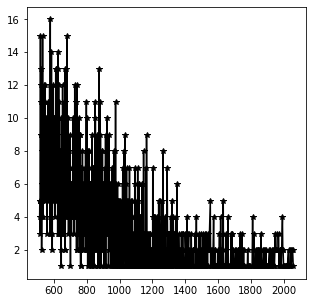

In [200]:
from collections import Counter

count_len = Counter(train_len)
count_len = sorted(count_len.items())
x = [x[0] for x in count_len]
y = [x[1] for x in count_len]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(x, y,
        color='black',
        marker='*',
        linestyle='solid', 
       )

plt.show()


<AxesSubplot:>

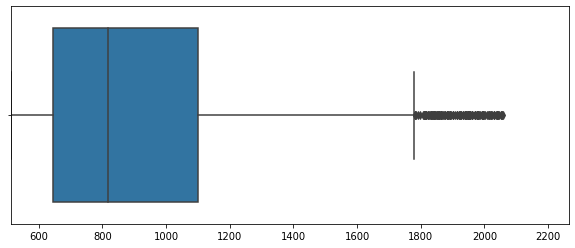

In [108]:
plt.figure(figsize=(10,4))
plt.xlim(train_len.min(), train_len.max()*1.1)
sns.boxplot(x=train_len)

In [109]:
print('가장 긴 train context 길이:', train_len.max())
print('평균 train context 길이:', train_len.mean())
print('가장 짧은 train context 길이:', train_len.min())

가장 긴 train context 길이: 2059.0
평균 train context 길이: 920.2206477732793
가장 짧은 train context 길이: 512.0


#### validation context 분포

<AxesSubplot:>

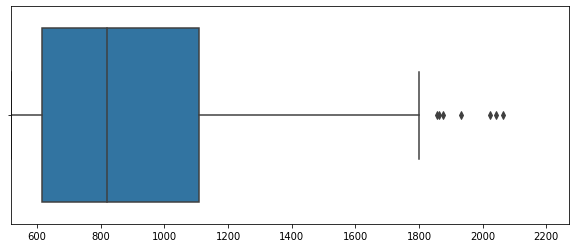

In [110]:
plt.figure(figsize=(10,4))
plt.xlim(val_len.min(), val_len.max()*1.1)
sns.boxplot(x=val_len)

In [111]:
print('가장 긴 validation context 길이:', val_len.max())
print('평균 validation context 길이:', val_len.mean())
print('가장 짧은 validation context 길이:', val_len.min())

가장 긴 validation context 길이: 2064.0
평균 validation context 길이: 916.725
가장 짧은 validation context 길이: 517.0


#### train/val question 분포

In [115]:
train_questions = datasets['train']['question']
val_questions = datasets['validation']['question']

In [119]:
train_q_len = np.array([])
for doc in train_questions:
    train_q_len = np.append(train_q_len, len(doc))

val_q_len = np.array([])
for doc in val_questions:
    val_q_len = np.append(val_q_len, len(doc))

In [121]:
print('가장 긴 train question 길이:', train_q_len.max())
print('평균 train question 길이:', train_q_len.mean())
print('가장 짧은 train question 길이:', train_q_len.min())

가장 긴 train question 길이: 78.0
평균 train question 길이: 29.32236842105263
가장 짧은 train question 길이: 8.0


In [120]:
print('가장 긴 validation question 길이:', val_q_len.max())
print('평균 validation question 길이:', val_q_len.mean())
print('가장 짧은 validation question 길이:', val_q_len.min())

가장 긴 validation question 길이: 59.0
평균 validation question 길이: 29.195833333333333
가장 짧은 validation question 길이: 9.0


<AxesSubplot:>

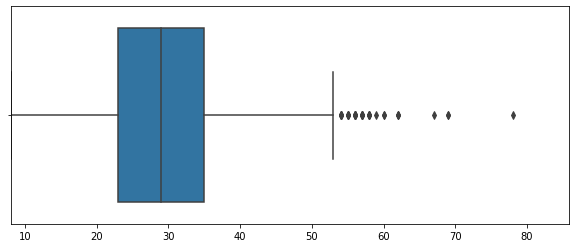

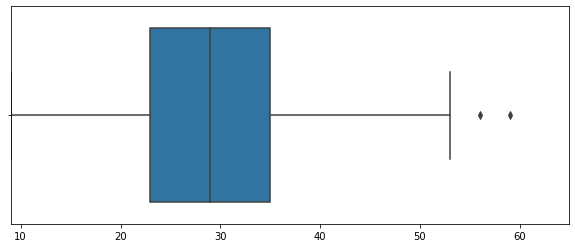

In [126]:
plt.figure(figsize=(10,4))
plt.xlim(train_q_len.min(), train_q_len.max()*1.1)
sns.boxplot(x=train_q_len)

plt.figure(figsize=(10,4))
plt.xlim(val_q_len.min(), val_q_len.max()*1.1)
sns.boxplot(x=val_q_len)

In [140]:
np.where(train_q_len == 78)
print('train에서 가장 긴 질문')
print(train_questions[1840])
print()
print('train에서 가장 짧은 질문')
for q in np.where(train_q_len == 8)[0]:
    print(train_questions[q])

train에서 가장 긴 질문
사전처분에도 불구하고 양육 부모가 비양육 부모에게 아이를 보여주지 않을 때 위반 행위자에게 1천만원 이하의 과태료를 부과할 수 있는 제도는?

train에서 가장 짧은 질문
연희의 직업은?
훈다손의 뜻은?


In [142]:
print('validation에서 가장 긴 질문')
for q in np.where(val_q_len == 59)[0]:
    print(val_questions[q])
print()
print('validation에서 가장 짧은 질문')
for q in np.where(val_q_len == 9)[0]:
    print(val_questions[q])

validation에서 가장 긴 질문
베르니츠 강과 라슈트 강이 만나는 곳 부근에서 코네티컷 연대와 만나 전투를 벌였던 프랑스 부대는 어디인가?

validation에서 가장 짧은 질문
마이어의 사인은?


#### train/val answer 분포

In [153]:
train_answers = []
for a in datasets['train']['answers']:
    train_answers.append(a['text'][0])
val_answers = []
for a in datasets['validation']['answers']:
    val_answers.append(a['text'][0])

In [154]:
train_a_len = np.array([])
for doc in train_answers:
    train_a_len = np.append(train_a_len, len(doc))

val_a_len = np.array([])
for doc in val_answers:
    val_a_len = np.append(val_a_len, len(doc))

In [158]:
print('가장 긴 train answer 길이:', train_a_len.max())
print('평균 train answer 길이:', train_a_len.mean())
print('가장 짧은 train answer 길이:', train_a_len.min())

가장 긴 train answer 길이: 83.0
평균 train answer 길이: 6.275050607287449
가장 짧은 train answer 길이: 1.0


In [169]:
print('가장 긴 validation answer 길이:', val_a_len.max())
print('평균 validation answer 길이:', val_a_len.mean())
print('가장 짧은 validation answer 길이:', val_a_len.min())

가장 긴 validation answer 길이: 64.0
평균 validation answer 길이: 6.9125
가장 짧은 validation answer 길이: 1.0


<AxesSubplot:>

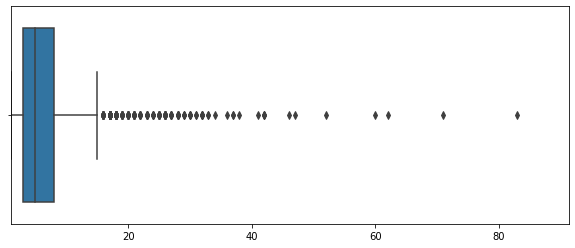

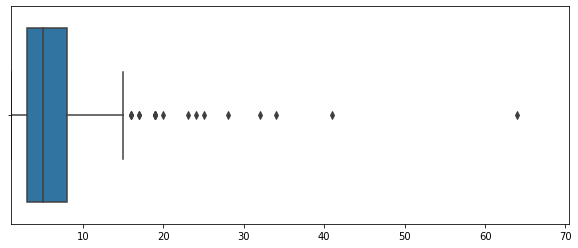

In [157]:
plt.figure(figsize=(10,4))
plt.xlim(train_a_len.min(), train_a_len.max()*1.1)
sns.boxplot(x=train_a_len)

plt.figure(figsize=(10,4))
plt.xlim(val_a_len.min(), val_a_len.max()*1.1)
sns.boxplot(x=val_a_len)

In [167]:
count = 0 
for a in train_answers:
    if len(a) > 30:
        print(a)
        count += 1

print('percentage of answers longer than 30:', count/len(train_answers) * 100)

≪인간의 이해: 개념의 집단적 사용 및 진화 (1972)≫
〈성당과 시장〉(The Cathedral and the Bazaar)
룬그로 (이탈리아 대륙에 거주하는 아르버레셔인을 위한) 교구
"오 그 불쌍한 사람들... 그러나 그건 별로 중요하지 않아요! 중요한건 난 새로운 배달원이 필요했다는 거지!"
최근의 반도의 경제사범 ­국민의 신경제 윤리의 파악을 위하여­
도스토옙스키가 침대 누워 구술한 것을 아내 안나가 속기 하여
독일의 고전 문헌학자 헤르만 딜스가 이들 철학자의 단편들을 한데 모아 엮은 책의 제목
시리아킬리키아 포에니케 (Syria-Cilicia Phoenice)
“나는 국경일에 일장기를 게양하는 것을 반대하지 않는다. 왜냐하면 우리가 일본의 통치하에 있는 한 우리는 그 통치의 명령에 복종해야 하기 때문이다.”
에모리 대학(Oxford College of Emory University)
머리가 크고, 가늘고 허약해 보이는 동체를 꼬아놓은 모습
“나리타처럼 되지 말자(成田のようにならないようにしよう )”
프레드릭 S. 보아스 (Frederick S. Boas)
고문서로 발견된 유물이 원어로는 존재하지 않고 번역된 언어로만 존재할 경우
당대의 바빌로니아 기록들이 현재까지 별로 많이 남아있지 않기 때문
샤 자한이 이 무덤을 지을 때 자신이 그녀의 옆에 묻힐 것을 예상하지 못하였기 때문
형태에 있어 거의 혹은 전혀 자유가 없어 다양한 번역을 창조해내기가 불가능하고 시구 구조에서도 다른 여지를 찾기 어려운 탓이다.
"소유의 절반을 가난한 자들에게 주겠으며, 만일 누구의 것을 부당하게 취한 일이 있으며 사 배나 보상할 것"
“부르주아 독재(Dictatorship of the bourgeoisie)”
한겨레가 삼성에 대해 악의적인 보도로 일관하고 있다고 판단
매킨토시와 도스 상에서 ‘설정 가능한’ 플랫 파일 데이터베이스 응용 프로그램
주거 및 상업시설 복합 건축물의 상업 지역 부분 옥상 등지
제9번이 마지막 교향곡이 된다는 운명적 신화 (9번 교향곡의 저주)
황도철

In [168]:
count = 0
for a in val_answers:
    if len(a) > 30:
        print(a)
        count += 1

print('percentage of answers longer than 30:',count/len(val_answers) * 100)

깃털 셔틀콕의 타구감을 선호하고, 또한 플라스틱보다 깃털 셔틀콕이 정교한 컨트롤을 하기에 보다 더 적합하기 때문이다
본국 의회가 식민지에 대한 입법을 “어떤 경우에도 행할 수” 있도록 하였다
걸프 카르텔(카르텔 델 골포: Cartel del golfo)
트르피미로비치 왕조(Trpimirović) 출신의 문치미르
percentage of answers longer than 30: 1.6666666666666667


#### Titles

In [186]:
df = pd.DataFrame()
df = df.assign(title=datasets['train']['title'])
df = df.assign(answer=train_answers)
df

,title,answer
0,미국 상원,하원
1,인사조직관리,《경영의 실제》
2,강희제,백성
3,금동삼존불감,중국
4,계사명 사리구,4개
...,...,...
3947,이오 (위성),지질 구조
3948,내니 다이어리,뉴저지
3949,빈 필하모니 관현악단,칼 에케르트
3950,드래곤,슬라브 신화


In [188]:
df = pd.DataFrame()
df = df.assign(title=datasets['validation']['title'])
df = df.assign(answer=val_answers)
df

,title,answer
0,전효숙,한보철강
1,스토우빌선,1871년
2,촐라,나뭇잎
3,백조 기사,금대야
4,탈관료제화,수평적 관계
...,...,...
235,전단 (제나라),제 양왕
236,티칼,'일곱 개의 신전 광장'
237,윤치호,미나미 지로
238,신잉카국,"200,000명"


#### 중복 찾기

In [8]:
print(len(wiki_corpus))

56737


In [18]:
print(len(contexts))

3504


In [13]:
wiki_corpus = set(wiki_corpus)
contexts = set(contexts)

a = wiki_corpus & contexts
print(len(a))

3504


In [14]:
val_corpus = datasets['validation']['context']

In [15]:
len(list(set(val_corpus)))

235

In [44]:
train_corpus = datasets['train']['context']

In [45]:
len(list(set(train_corpus)))

3340

In [46]:
len(train_corpus)

3952

In [49]:
print(datasets)
datasets['train']['answers']

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 240
    })
})


[{'answer_start': [235], 'text': ['하원']},
 {'answer_start': [212], 'text': ['《경영의 실제》']},
 {'answer_start': [510], 'text': ['백성']},
 {'answer_start': [625], 'text': ['중국']},
 {'answer_start': [30], 'text': ['4개']},
 {'answer_start': [91], 'text': ['드래곤']},
 {'answer_start': [68], 'text': ['형양태수 왕식']},
 {'answer_start': [583], 'text': ['이탈리아군']},
 {'answer_start': [195], 'text': ['큰아들 유']},
 {'answer_start': [861], 'text': ['왕대마을']},
 {'answer_start': [817], 'text': ['음독자살']},
 {'answer_start': [414], 'text': ['출장 잦은 건축가']},
 {'answer_start': [86], 'text': ['반신화적인 인물인 우파']},
 {'answer_start': [26], 'text': ['1951년']},
 {'answer_start': [497], 'text': ['예수']},
 {'answer_start': [524], 'text': ["'초일기'"]},
 {'answer_start': [414], 'text': ['1916년']},
 {'answer_start': [13], 'text': ['레드삭스']},
 {'answer_start': [228], 'text': ['삼판동']},
 {'answer_start': [585], 'text': ['다산 정약용']},
 {'answer_start': [166], 'text': ['대나라']},
 {'answer_start': [142], 'text': ['10달러']},
 {'answer_start': [59], 

In [53]:
df = pd.DataFrame(datasets['train']['context'], columns=['context'])
df['question'] = pd.DataFrame(datasets['train']['question'])
val_answers = []
for a in datasets['train']['answers']:
    val_answers.append(a['text'][0])
df['answers'] = pd.DataFrame(val_answers)

In [54]:
df

,context,question,answers
0,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,하원
1,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,《경영의 실제》
2,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,백성
3,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,중국
4,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,4개
...,...,...,...
3947,이오의 산\n이오의 산 목록\n 이오에는 100~150개의 산이 있다. 이들 산의 ...,대부분의 이오의 산이 형성되는데 영향을 끼친 것은?,지질 구조
3948,애니의 고군분투 뉴욕 입성기!!\n\n인류학자가 꿈인 21살 소녀 '애니(스칼렛 요...,애니는 어디서 태어났는가?,뉴저지
3949,1842년에 작곡가이자 지휘자인 오토 니콜라이가 빈 궁정 오페라극장 소속 관현악단을...,1854년에 니콜라이의 뒤를 이어 상임 지휘자로서 활동한 인물은?,칼 에케르트
3950,원어는 고대 그리스어까지 거슬러 올라간다. 영어 문헌에 이 말이 나타나기 시작한 것...,드래곤의 암수 구분이 있는 신화는?,슬라브 신화


In [55]:
df.duplicated(['context'])

0       False
1       False
2       False
3       False
4       False
        ...  
3947     True
3948    False
3949    False
3950     True
3951     True
Length: 3952, dtype: bool

In [56]:
df = df.drop_duplicates(['context'], keep='first')
df


,context,question,answers
0,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,하원
1,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,《경영의 실제》
2,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,백성
3,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,중국
4,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,4개
...,...,...,...
3942,"378년 4월, 부견은 부비(符丕)에게 17만을 주고 동진의 양양을 공격케했다. 그...",부견의 동진 공격을 지지한 사람은?,모용수
3944,감시 시스템에 대해 성찰해야 한다.\n\n2003년 시민들은 프라이버시를 지키기 위...,역감시는 무엇의 보호를 위한 활동인가요?,자신의 프라이버시
3945,"1940년, 제2차 세계 대전에 대비하기 위해 알래스카 방위군이 창설되었다. 랜드리...",알래스카 고속도로가 미국 본토에 수행하는 역할은?,병력과 물류를 보급할 통로
3948,애니의 고군분투 뉴욕 입성기!!\n\n인류학자가 꿈인 21살 소녀 '애니(스칼렛 요...,애니는 어디서 태어났는가?,뉴저지


In [57]:
df.to_csv('remove_dup.csv')